In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
# --- Core Computational Utilities ---

def compute_spectral_norm(matrix):
    """
    Computes the spectral norm of a matrix.
    """
    
    return torch.linalg.matrix_norm(matrix, ord=2)

In [3]:
def compute_l21_norm(matrix):
    """
    Computes the L(2,1) norm of a matrix: L2 norm of columns, then L1 of the result.
    """
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))

In [4]:
# --- Main Calculation Engine ---

def compute_spectral_complexity(model: nn.Module):
    """
    Computes the spectral complexity R_A for a given PyTorch model.
    """
    product_terms = list()
    summation_terms = list()
    
    device = next(model.parameters()).device

    max_layer_time = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Processing layer: {name} of type {type(module).__name__}")

            A_i = module.weight.data
            rho_i = 1.0  # Lipschitz constant for ReLU is 1
            
            start_time = time.perf_counter()

            if A_i.dim() == 4:
                A_i = A_i.view(A_i.size(0), -1)
            
            # 1. Compute spectral norm and product term
            s_i = compute_spectral_norm(A_i)
            
            
            
            # 2. Construct the reference matrix M_i
            M_i = torch.eye(A_i.size(0), A_i.size(1), device=device)
            
            # 3. Compute the deviation term for the summation
            # Formula requires ||A_i^T - M_i^T||_{2,1}
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            
            # Add a small epsilon to avoid division by zero if spectral norm is 0
            # sum_term = (deviation_norm**(2/3)) / ((s_i + 1e-12)**(2/3))
            sum_term = (deviation_norm / s_i)**(2/3)
            end_time = time.perf_counter()

            max_layer_time = max(max_layer_time, end_time - start_time)
            # sum_term = (deviation_norm / s_i)**(2/3)
            summation_terms.append(sum_term)
            product_terms.append(rho_i * s_i)

    # Calculate the final components
    # Product term: prod(rho_i * ||A_i||_sigma)
    total_product = torch.prod(torch.stack(product_terms))
    
    # Summation term: (sum(...))^(3/2)
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum**(3/2)
    
    # Final Spectral Complexity R_A
    R_A = total_product * final_sum_term

    print(f"Maximum Computation Time for Layer: {max_layer_time:.4f}s")
    
    return R_A, total_product, final_sum_term

In [7]:
def compute_gamma_distribution(model_path):
    print("Loading pretrained ResNet-18 model...")
    resnet18_cifar10_normal = models.resnet18(pretrained=False) # Set to True for transfer learning
    
    # Modify the first conv layer for CIFAR-10 input size
    resnet18_cifar10_normal.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    resnet18_cifar10_normal.maxpool = nn.Identity() # Remove maxpool for smaller images
    
    # Modify the final fully connected layer for 10 classes
    num_ftrs = resnet18_cifar10_normal.fc.in_features
    resnet18_cifar10_normal.fc = nn.Linear(num_ftrs, 10)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    resnet18_cifar10_normal = resnet18_cifar10_normal.to(device)
    
    resnet18_cifar10_normal.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
    # Set the model to evaluation mode
    resnet18_cifar10_normal.eval()
        
    # Compute the spectral complexity
    print("\nComputing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(resnet18_cifar10_normal)
    end_time = time.perf_counter()
    print(f"Total Computation Time: {end_time - start_time:.4f}s")
        
    print("\n--- Results ---")
    print(f"Product Component (Lipschitz-like term): {product_component.item():.4e}")
    print(f"Summation Component (Structural Deviation term): {sum_component.item():.4e}")
    print(f"Total Spectral Complexity (R_A): {spectral_complexity.item():.4e}")

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    diffs = []
    data_l2_norm = 0
    num_samples = len(testset)
    
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = resnet18_cifar10_normal(inputs)
            top2 = torch.topk(outputs, k=2, dim=1).values
            diffs.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())
            data_l2_norm += torch.sum(inputs**2)
    
    normal_diffs = np.array(diffs)/(spectral_complexity.item() * (torch.sqrt(data_l2_norm) / num_samples))

    return normal_diffs

    # return np.array(diffs)

In [8]:
underfit = compute_gamma_distribution("ckpt_resnet18_cifar10/epoch_2.pth")
correct = compute_gamma_distribution("ckpt_resnet18_cifar10/epoch_29.pth")
overfit = compute_gamma_distribution("ckpt_resnet18_cifar10/epoch_98.pth")

Loading pretrained ResNet-18 model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Proc

Eval: 100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Loading pretrained ResNet-18 model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Proc

Eval: 100%|██████████| 79/79 [00:11<00:00,  6.97it/s]


Loading pretrained ResNet-18 model...

Computing spectral complexity...
Processing layer: conv1 of type Conv2d
Processing layer: layer1.0.conv1 of type Conv2d
Processing layer: layer1.0.conv2 of type Conv2d
Processing layer: layer1.1.conv1 of type Conv2d
Processing layer: layer1.1.conv2 of type Conv2d
Processing layer: layer2.0.conv1 of type Conv2d
Processing layer: layer2.0.conv2 of type Conv2d
Processing layer: layer2.0.downsample.0 of type Conv2d
Processing layer: layer2.1.conv1 of type Conv2d
Processing layer: layer2.1.conv2 of type Conv2d
Processing layer: layer3.0.conv1 of type Conv2d
Processing layer: layer3.0.conv2 of type Conv2d
Processing layer: layer3.0.downsample.0 of type Conv2d
Processing layer: layer3.1.conv1 of type Conv2d
Processing layer: layer3.1.conv2 of type Conv2d
Processing layer: layer4.0.conv1 of type Conv2d
Processing layer: layer4.0.conv2 of type Conv2d
Processing layer: layer4.0.downsample.0 of type Conv2d
Processing layer: layer4.1.conv1 of type Conv2d
Proc

Eval: 100%|██████████| 79/79 [00:08<00:00,  9.18it/s]


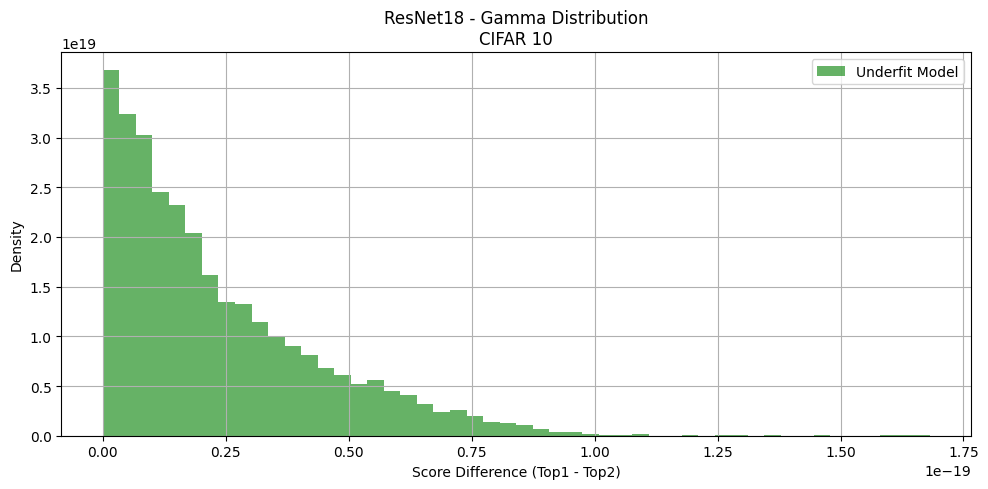

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

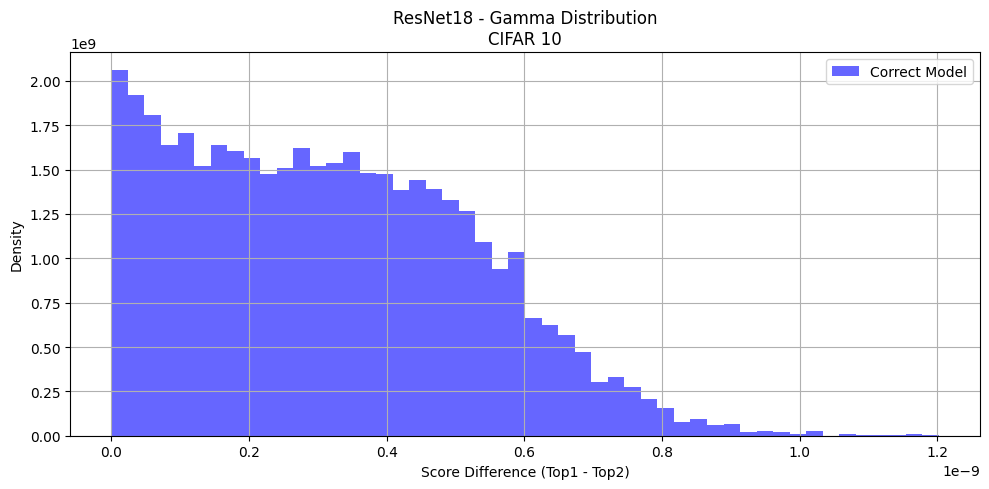

In [10]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

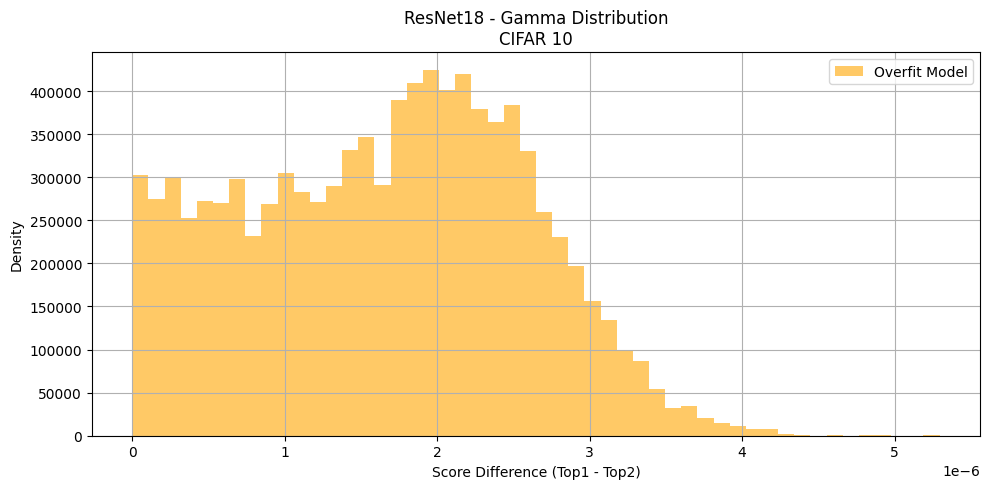

In [11]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

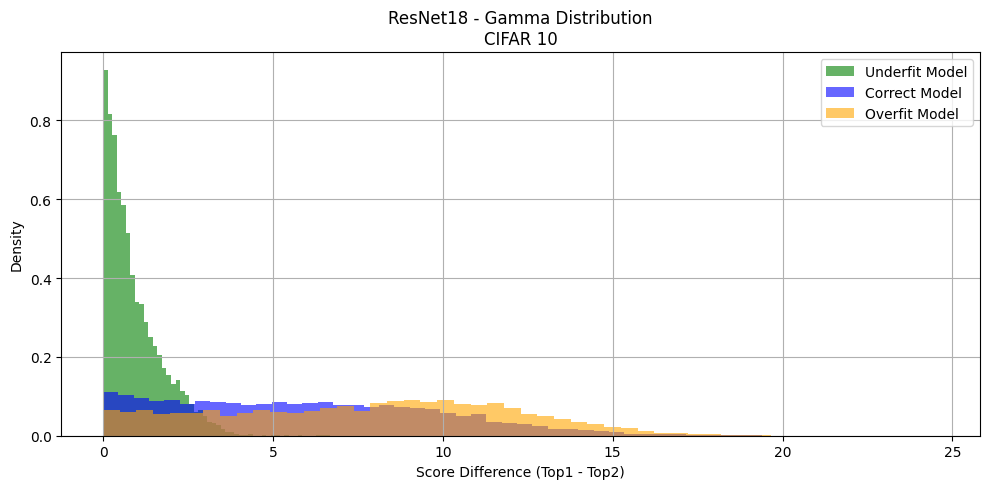

In [7]:
plt.figure(figsize=(10, 5))
plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [5]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True) # Set to True for transfer learning

# Modify the first conv layer for CIFAR-10 input size
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity() # Remove maxpool for smaller images

# Modify the final fully connected layer for 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

/home/samanway/.conda/envs/torch_gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samanway/.conda/envs/torch_gpu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 100 # Adjust as needed

train_acc = list()
test_acc = list()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    # print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    torch.save(model.state_dict(), f"ckpt_resnet18_cifar10/epoch_{epoch+1}.pth")

Eval: 100%|██████████| 79/79 [00:01<00:00, 55.82it/s]


Epoch 1, Loss: 1.5988, train acc: 40.64%, test acc: 43.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.25it/s]


Epoch 2, Loss: 1.4832, train acc: 45.03%, test acc: 47.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.48it/s]


Epoch 3, Loss: 1.3495, train acc: 50.84%, test acc: 52.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.22it/s]


Epoch 4, Loss: 1.1969, train acc: 57.01%, test acc: 56.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.75it/s]


Epoch 5, Loss: 1.0590, train acc: 62.36%, test acc: 62.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.20it/s]


Epoch 6, Loss: 0.9172, train acc: 67.81%, test acc: 63.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.50it/s]


Epoch 7, Loss: 0.8180, train acc: 71.14%, test acc: 72.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.38it/s]


Epoch 8, Loss: 0.7088, train acc: 75.14%, test acc: 75.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.37it/s]


Epoch 9, Loss: 0.6286, train acc: 78.01%, test acc: 76.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.92it/s]


Epoch 10, Loss: 0.5647, train acc: 80.22%, test acc: 76.66%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.40it/s]


Epoch 11, Loss: 0.5237, train acc: 81.67%, test acc: 76.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.31it/s]


Epoch 12, Loss: 0.4771, train acc: 83.44%, test acc: 78.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.02it/s]


Epoch 13, Loss: 0.4479, train acc: 84.50%, test acc: 80.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.98it/s]


Epoch 14, Loss: 0.4220, train acc: 85.25%, test acc: 77.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.78it/s]


Epoch 15, Loss: 0.3961, train acc: 86.08%, test acc: 80.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.12it/s]


Epoch 16, Loss: 0.3789, train acc: 86.83%, test acc: 82.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.38it/s]


Epoch 17, Loss: 0.3522, train acc: 87.86%, test acc: 80.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.29it/s]


Epoch 18, Loss: 0.3394, train acc: 88.28%, test acc: 82.53%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.51it/s]


Epoch 19, Loss: 0.3225, train acc: 88.84%, test acc: 84.22%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.18it/s]


Epoch 20, Loss: 0.3093, train acc: 89.29%, test acc: 84.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.19it/s]


Epoch 21, Loss: 0.2923, train acc: 89.93%, test acc: 83.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s]


Epoch 22, Loss: 0.2789, train acc: 90.18%, test acc: 83.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.39it/s]


Epoch 23, Loss: 0.2705, train acc: 90.41%, test acc: 85.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.38it/s]


Epoch 24, Loss: 0.2592, train acc: 91.00%, test acc: 83.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.67it/s]


Epoch 25, Loss: 0.2508, train acc: 91.26%, test acc: 79.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.53it/s]


Epoch 26, Loss: 0.2441, train acc: 91.42%, test acc: 85.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.02it/s]


Epoch 27, Loss: 0.2378, train acc: 91.67%, test acc: 84.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.76it/s]


Epoch 28, Loss: 0.2332, train acc: 91.85%, test acc: 85.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


Epoch 29, Loss: 0.2211, train acc: 92.19%, test acc: 87.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.98it/s]


Epoch 30, Loss: 0.2196, train acc: 92.43%, test acc: 85.48%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.74it/s]


Epoch 31, Loss: 0.2165, train acc: 92.37%, test acc: 77.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.41it/s]


Epoch 32, Loss: 0.2056, train acc: 92.78%, test acc: 85.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.22it/s]


Epoch 33, Loss: 0.2007, train acc: 92.93%, test acc: 83.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.85it/s]


Epoch 34, Loss: 0.1963, train acc: 93.13%, test acc: 84.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


Epoch 35, Loss: 0.1904, train acc: 93.29%, test acc: 84.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.70it/s]


Epoch 36, Loss: 0.1790, train acc: 93.82%, test acc: 87.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.42it/s]


Epoch 37, Loss: 0.1816, train acc: 93.67%, test acc: 85.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.34it/s]


Epoch 38, Loss: 0.1820, train acc: 93.64%, test acc: 82.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.92it/s]


Epoch 39, Loss: 0.1760, train acc: 93.93%, test acc: 85.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


Epoch 40, Loss: 0.1649, train acc: 94.28%, test acc: 86.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.52it/s]


Epoch 41, Loss: 0.1794, train acc: 93.79%, test acc: 87.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.03it/s]


Epoch 42, Loss: 0.1588, train acc: 94.55%, test acc: 86.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.76it/s]


Epoch 43, Loss: 0.1557, train acc: 94.49%, test acc: 87.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.96it/s]


Epoch 44, Loss: 0.1596, train acc: 94.47%, test acc: 88.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.73it/s]


Epoch 45, Loss: 0.1510, train acc: 94.84%, test acc: 87.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.48it/s]


Epoch 46, Loss: 0.1490, train acc: 94.81%, test acc: 84.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.77it/s]


Epoch 47, Loss: 0.1548, train acc: 94.66%, test acc: 85.73%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.21it/s]


Epoch 48, Loss: 0.1444, train acc: 94.99%, test acc: 86.58%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.58it/s]


Epoch 49, Loss: 0.1422, train acc: 95.02%, test acc: 85.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.81it/s]


Epoch 50, Loss: 0.1384, train acc: 95.09%, test acc: 86.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.13it/s]


Epoch 51, Loss: 0.1370, train acc: 95.17%, test acc: 85.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.17it/s]


Epoch 52, Loss: 0.1377, train acc: 95.11%, test acc: 89.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.87it/s]


Epoch 53, Loss: 0.1376, train acc: 95.24%, test acc: 86.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.93it/s]


Epoch 54, Loss: 0.1323, train acc: 95.29%, test acc: 85.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.90it/s]


Epoch 55, Loss: 0.1282, train acc: 95.59%, test acc: 88.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.66it/s]


Epoch 56, Loss: 0.1218, train acc: 95.81%, test acc: 88.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.31it/s]


Epoch 57, Loss: 0.1261, train acc: 95.72%, test acc: 87.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s]


Epoch 58, Loss: 0.1214, train acc: 95.73%, test acc: 88.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s]


Epoch 59, Loss: 0.1157, train acc: 96.04%, test acc: 88.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.89it/s]


Epoch 60, Loss: 0.1226, train acc: 95.64%, test acc: 87.63%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.38it/s]


Epoch 61, Loss: 0.1186, train acc: 95.93%, test acc: 87.65%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.08it/s]


Epoch 62, Loss: 0.1120, train acc: 96.10%, test acc: 86.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.55it/s]


Epoch 63, Loss: 0.1139, train acc: 96.09%, test acc: 88.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.23it/s]


Epoch 64, Loss: 0.1083, train acc: 96.25%, test acc: 88.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.04it/s]


Epoch 65, Loss: 0.1103, train acc: 96.24%, test acc: 87.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.28it/s]


Epoch 66, Loss: 0.1015, train acc: 96.59%, test acc: 87.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.60it/s]


Epoch 67, Loss: 0.1034, train acc: 96.42%, test acc: 86.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.93it/s]


Epoch 68, Loss: 0.0982, train acc: 96.65%, test acc: 86.40%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s]


Epoch 69, Loss: 0.0970, train acc: 96.66%, test acc: 88.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


Epoch 70, Loss: 0.1023, train acc: 96.45%, test acc: 88.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.02it/s]


Epoch 71, Loss: 0.0982, train acc: 96.55%, test acc: 88.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.10it/s]


Epoch 72, Loss: 0.0979, train acc: 96.62%, test acc: 88.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.37it/s]


Epoch 73, Loss: 0.0903, train acc: 96.94%, test acc: 89.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.94it/s]


Epoch 74, Loss: 0.0903, train acc: 96.95%, test acc: 87.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.40it/s]


Epoch 75, Loss: 0.0939, train acc: 96.80%, test acc: 86.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.41it/s]


Epoch 76, Loss: 0.0939, train acc: 96.87%, test acc: 89.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.40it/s]


Epoch 77, Loss: 0.0791, train acc: 97.32%, test acc: 89.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.22it/s]


Epoch 78, Loss: 0.0810, train acc: 97.28%, test acc: 90.41%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


Epoch 79, Loss: 0.0844, train acc: 97.12%, test acc: 88.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.06it/s]


Epoch 80, Loss: 0.0820, train acc: 97.22%, test acc: 87.69%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.38it/s]


Epoch 81, Loss: 0.0752, train acc: 97.45%, test acc: 88.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.15it/s]


Epoch 82, Loss: 0.0785, train acc: 97.33%, test acc: 87.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.22it/s]


Epoch 83, Loss: 0.0786, train acc: 97.35%, test acc: 89.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.38it/s]


Epoch 84, Loss: 0.0751, train acc: 97.56%, test acc: 88.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.65it/s]


Epoch 85, Loss: 0.0747, train acc: 97.44%, test acc: 87.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.26it/s]


Epoch 86, Loss: 0.0713, train acc: 97.63%, test acc: 88.64%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.96it/s]


Epoch 87, Loss: 0.0708, train acc: 97.63%, test acc: 88.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.77it/s]


Epoch 88, Loss: 0.0645, train acc: 97.80%, test acc: 89.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.53it/s]


Epoch 89, Loss: 0.0673, train acc: 97.72%, test acc: 89.50%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.60it/s]


Epoch 90, Loss: 0.0661, train acc: 97.74%, test acc: 87.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.21it/s]


Epoch 91, Loss: 0.0647, train acc: 97.81%, test acc: 90.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.68it/s]


Epoch 92, Loss: 0.0660, train acc: 97.74%, test acc: 90.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.87it/s]


Epoch 93, Loss: 0.0595, train acc: 98.08%, test acc: 88.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.05it/s]


Epoch 94, Loss: 0.0585, train acc: 98.04%, test acc: 90.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.14it/s]


Epoch 95, Loss: 0.0626, train acc: 97.88%, test acc: 89.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.16it/s]


Epoch 96, Loss: 0.0599, train acc: 97.99%, test acc: 90.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.61it/s]


Epoch 97, Loss: 0.0558, train acc: 98.11%, test acc: 89.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.55it/s]


Epoch 98, Loss: 0.0576, train acc: 98.12%, test acc: 88.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.55it/s]


Epoch 99, Loss: 0.0564, train acc: 98.12%, test acc: 90.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 55.80it/s]


Epoch 100, Loss: 0.0499, train acc: 98.32%, test acc: 90.61%


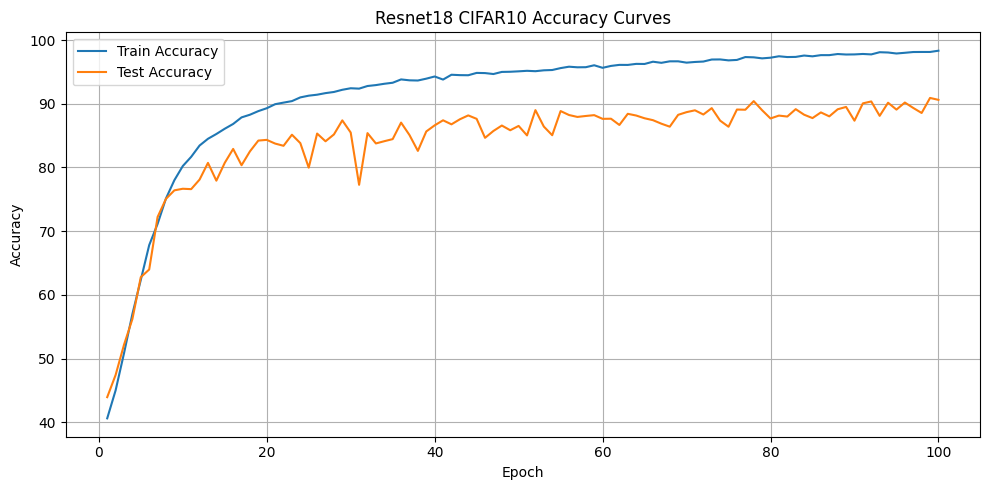

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Resnet18 CIFAR10 Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"resnet18_cifar10_accuracy_curve.png")
plt.show()